# Assignment 2  

### MACS 30000, Dr. Evans
### Dongcheng Yang  
### Oct. 11 

In [57]:
# Import packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# plt.style.use('seaborn')

### 1. imputing age and gender

#### (a)  The procedures of imputing age and gender are as follows:  
1) Regress age and female seperately on the variables total income and weight by using SurvIncome dataset  
     The regression equations are:  
     $$ age_i=\beta_0+\beta_1*totalincome_i+\beta_2*weight_i+\epsilon_i $$  
     $$ female_i=\beta_0+\beta_1*totalincome_i+\beta_2*weight_i+\epsilon_i $$  
2) Compute total income in BestIncome dataset by adding up variables "lab_inc" and "cap_inc"  
3) Use the created variable total income and weight from BestIncome dataset and the two linear regressions above to impute age and gender  
4) For the computed gender variables with value more than 0.5, let it equal to 1 as a representative of female

In [53]:
# Define Data
SI = pd.read_csv('SurvIncome.txt', index_col=0,header=None).reset_index()
SI.columns=["tot_inc","wgti","age","female"]
print(SI.head())
BI = pd.read_csv('BestIncome.txt', index_col=0,header=None).reset_index()
BI.columns=["lab_inc","cap_inc","hgt","wgt"]
print(BI.head())

        tot_inc        wgti        age  female
0  63642.513655  134.998269  46.610021     1.0
1  49177.380692  134.392957  48.791349     1.0
2  67833.339128  126.482992  48.429894     1.0
3  62962.266217  128.038121  41.543926     1.0
4  58716.952597  126.211980  41.201245     1.0
        lab_inc       cap_inc        hgt         wgt
0  52655.605507   9279.509829  64.568138  152.920634
1  70586.979225   9451.016902  65.727648  159.534414
2  53738.008339   8078.132315  66.268796  152.502405
3  55128.180903  12692.670403  62.910559  149.218189
4  44482.794867   9812.975746  68.678295  152.726358


#### (b) Here is where I'll use my proposed method from part (a) to impute variables.

In [54]:
# regression of age on tot_inc and wgti
outcome  ='age'
features = ['tot_inc', 'wgti']
X, y = SI[features], SI[outcome]
X_vars = sm.add_constant(X, prepend=False)
m = sm.OLS(y, X_vars)
res = m.fit()
print(res.summary())

#Getting Age With a Custom Formula
def get_age(row):
    tot_inc = row[0]
    wgt=row[1]
    age = 44.2097+(tot_inc* 2.52e-05)+(wgt*(-0.0067))
    return age

# Impute Variable Age
BI['tot_inc']=BI['lab_inc']+BI['cap_inc']
BI['imputed_age'] = BI[['tot_inc', 'wgt']].apply(get_age, axis=1)
BI.head()

# regression of gender on tot_inc and wgti
outcome  ='female'
features = ['tot_inc', 'wgti']
X, y = SI[features], SI[outcome]
X_vars = sm.add_constant(X, prepend=False)
m = sm.OLS(y, X_vars)
res = m.fit()
print(res.summary())

#Getting Gender With a Custom Formula
def get_gender(row):
    tot_inc = row[0]
    wgt=row[1]
    female = 3.7611+(tot_inc* (-5.25e-06))+(wgt*(-0.0195))
    return female

# Impute Variable Female
BI['imputed_female'] = BI[['tot_inc', 'wgt']].apply(get_gender, axis=1)

# Change imputed_female to int
BI['imputed_female'] = np.where(BI['imputed_female']>=0.5, 1, 0)
BI.head()

                            OLS Regression Results                            
Dep. Variable:                    age   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6326
Date:                Thu, 11 Oct 2018   Prob (F-statistic):              0.531
Time:                        16:49:19   Log-Likelihood:                -3199.4
No. Observations:                1000   AIC:                             6405.
Df Residuals:                     997   BIC:                             6419.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tot_inc      2.52e-05   2.26e-05      1.114      0.2

,lab_inc,cap_inc,hgt,wgt,tot_inc,imputed_age,imputed_female
0,52655.605507,9279.509829,64.568138,152.920634,61935.115336,44.745897,0
1,70586.979225,9451.016902,65.727648,159.534414,80037.996127,45.157777,0
2,53738.008339,8078.132315,66.268796,152.502405,61816.140654,44.745701,0
3,55128.180903,12692.670403,62.910559,149.218189,67820.851305,44.919024,0
4,44482.794867,9812.975746,68.678295,152.726358,54295.770612,44.554687,0


#### (c) Here is where I'll report the descriptive statistics for my new imputed variables.

In [56]:
#Get imputed_age Descriptive Stats
print(BI['imputed_age'].describe())
#Get imputed_female Descriptive Stats
print(BI['imputed_female'].describe())

count    10000.000000
mean        44.894036
std          0.219066
min         43.980016
25%         44.747065
50%         44.890281
75%         45.042239
max         45.706849
Name: imputed_age, dtype: float64
count    10000.000000
mean         0.470500
std          0.499154
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: imputed_female, dtype: float64


#### (d) Correlation matrix for the now six variables

In [59]:
# Correction Matrix
del BI['tot_inc']
corr = BI.corr()
corr.style.background_gradient()

,lab_inc,cap_inc,hgt,wgt,imputed_age,imputed_female
lab_inc,1,0.0053253,0.00278978,0.00450691,0.924329,-0.164857
cap_inc,0.0053253,1,0.0215716,0.00629868,0.234234,-0.0465937
hgt,0.00278978,0.0215716,1,0.172103,-0.0449272,-0.134172
wgt,0.00450691,0.00629868,0.172103,1,-0.299395,-0.778537
imputed_age,0.924329,0.234234,-0.0449272,-0.299395,1,0.0742876
imputed_female,-0.164857,-0.0465937,-0.134172,-0.778537,0.0742876,1


### 2. Stationarity and data drift

#### (a) Estimate by OLS and report coefficients

In [74]:
# Define Data
II = pd.read_csv('IncomeIntel.txt', index_col=0,header=None).reset_index()
II.columns=["grad_year","gre_qnt","salary_p4"] 
print(II.head())

# regression of salary_p4 on gre_qnt
outcome  ='salary_p4'
features = 'gre_qnt'
X, y = II[features], II[outcome]
X_vars = sm.add_constant(X, prepend=False)
m = sm.OLS(y, X_vars)
res = m.fit()
print(res.summary())

   grad_year     gre_qnt     salary_p4
0     2001.0  739.737072  67400.475185
1     2001.0  721.811673  67600.584142
2     2001.0  736.277908  58704.880589
3     2001.0  770.498485  64707.290345
4     2001.0  735.002861  51737.324165
                            OLS Regression Results                            
Dep. Variable:              salary_p4   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 15 Oct 2018   Prob (F-statistic):           3.43e-68
Time:                        11:59:12   Log-Likelihood:                -10673.
No. Observations:                1000   AIC:                         2.135e+04
Df Residuals:                     998   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                  

#### (b) Create a scatterplot of GRE score and graduation year. 

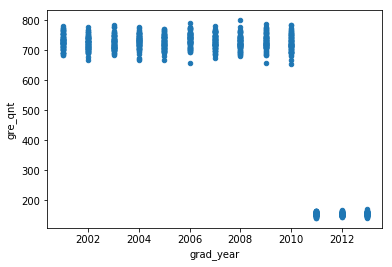

In [75]:
# Make scatterplot of GRE score and graduation year
# simple scatterplot using matplotlib
II.plot(x='grad_year', y='gre_qnt', kind='scatter')
plt.show()

From the scatterplot, we can see that at year 2011, the GRE underwent a substantial revision to its scoring system, which can be viewed as a drift. The solution to this problem is to create a one-to-one mapping that could transfer the score under current system to the previous. For score x,y seperately in current and previous system, I assume that the correlation can be roughly calculated as:  
$$ \frac{x-130}{170-130}= \frac{y-200}{800-200}$$


In [76]:
# Change the score after 2011 according to the mapping above
II['new_gre_qnt'] = np.where(II['grad_year']>=2011, (II['gre_qnt']-130)*15+200, II['gre_qnt'])
II.head()


,grad_year,gre_qnt,salary_p4,new_gre_qnt
0,2001.0,739.737072,67400.475185,739.737072
1,2001.0,721.811673,67600.584142,721.811673
2,2001.0,736.277908,58704.880589,736.277908
3,2001.0,770.498485,64707.290345,770.498485
4,2001.0,735.002861,51737.324165,735.002861


#### (c) Create a scatterplot of income and graduation year

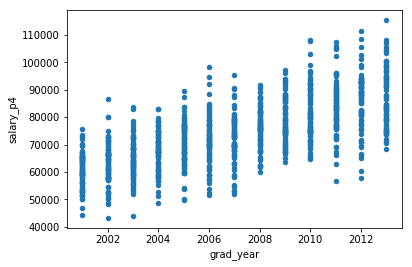

In [77]:
# Make scatterplot of income and graduation year
# simple scatterplot using matplotlib
II.plot(x='grad_year', y='salary_p4', kind='scatter')
plt.show()

The obvious problem here is that there is an increasing trend of the variable salary_p4. The procedures to deal with the problem are as follows:  
1) Treat the first year of the data grad_year=2001 equal to the base year.  
2) Calculate the average growth rate in salary by calculating the mean salary each year and calculating the average growth rate in salaries across all 13 years.  
3) Divide each salary according to the corresponding year and get a new salary variable.

   grad_year     gre_qnt     salary_p4  new_gre_qnt    new_salary
0     2001.0  739.737072  67400.475185   739.737072  67400.475185
1     2001.0  721.811673  67600.584142   721.811673  67600.584142
2     2001.0  736.277908  58704.880589   736.277908  58704.880589
3     2001.0  770.498485  64707.290345   770.498485  64707.290345
4     2001.0  735.002861  51737.324165   735.002861  51737.324165


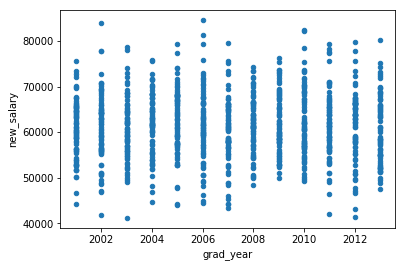

In [82]:
avg_inc_by_year = II['salary_p4'].groupby(II['grad_year']).mean().values
avg_growth_rate = ((avg_inc_by_year[1:] - avg_inc_by_year[:-1]) / avg_inc_by_year[:-1]).mean()
II['new_salary'] = II['salary_p4']/((1 + avg_growth_rate) ** (II['grad_year'] - 2001))
print(II.head())
II.plot(x='grad_year', y='new_salary', kind='scatter')
plt.show()

#### (d) Re-estimate coefficients with updated variables.

In [83]:
# Code to re-estimate, output of new coefficients
outcome  ='new_salary'
features = 'new_gre_qnt'
X, y = II[features], II[outcome]
X_vars = sm.add_constant(X, prepend=False)
m = sm.OLS(y, X_vars)
res = m.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             new_salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.05257
Date:                Tue, 16 Oct 2018   Prob (F-statistic):              0.819
Time:                        00:10:54   Log-Likelihood:                -10291.
No. Observations:                1000   AIC:                         2.059e+04
Df Residuals:                     998   BIC:                         2.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
new_gre_qnt    -0.6645      2.898     -0.229      

The estimated coefficient of the interest variable "gre_qnt" is now insignificant. This is because I put gre score in the same system, and delete the growth trend of salary data, which changed both variables' sample variance. With the unchanged regression results, we may conclude that there is a significant negative correlation between income and GRE quant scores, which violates the author's hypothesis. In this regression with transformed "gre_qnt" variable, we can see that this effect is insignificant, though the coefficient is still negative. 

### 3. Assessment of Kossinets and Watts.

See attached PDF. 